In [1]:
from scmodels import SCM
import random, math

In [2]:
def get_distributions():
    ep = .1
    dists = [
        f"LogLogistic(alpha={random.randint(5, 20)}, beta={round(random.uniform(1,3.5),1)})",
        f"Normal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"LogNormal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"Benini(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)}, sigma={round(random.random() + ep, 1)})",
        f"Beta(alpha={round(random.random() + ep, 1)}, beta={round(random.random() + ep, 1)})",
        f"Exponential(rate={round((random.random() + ep) * 10, 1)})",
        f"FDistribution(d1={random.randint(2, 4)}, d2={random.randint(5, 8)})",
        f"Gamma(k={round((random.random() + ep) * 4, 1)}, theta={round((random.random() + ep) * 8, 1)})",
        f"GammaInverse(a={round((random.random() + ep) * 4, 1)}, b={round((random.random() + ep) * 8, 1)})",
        f"Bernoulli({round(random.random(), 1)})",
        f"Binomial(n={random.randint(2, 10)}, p={round(random.random(), 1)}, succ={random.randint(3, 20)}, fail={random.randint(3, 20)})",
        f"BetaBinomial(n={random.randint(10, 100)}, alpha={round(random.random() + ep, 1)}, beta={round(random.uniform(2, 5),1)})",
        f"Die(sides={random.randint(4, 10)})",
        f"DiscreteUniform(items='1 2 3')",
        f"Geometric(p={round(random.random(), 2)})",
        f"Poisson(lamda={round(random.random() + ep, 1)})",
        f"FiniteRV({{{random.randint(5, 10)}: 1/2, {random.randint(0, 3)}: 1/6, {random.randint(15, 25)}: 1/6, {random.randint(30, 50)}: 1/6}})"
    ]
    
    return dists

In [3]:
def add_noise(dist):
    noise_ops = [False, True]
    op = random.choices(noise_ops, weights=(5, 1), k=1)[0]
    if op:
        dist = f"( {dist} ) * N"
    
    return dist

In [4]:
def add_complex_operation(dist):
    complex_ops = [False, "sqrt", "**2"]
    op = random.choices(complex_ops, weights=(10, 1, 1), k=1)[0]
    if op:
        if "*" in op:
            dist = f"( {dist} ){op}"
        else:
            dist = f"{op} ( {dist} )"
    
    return dist

In [5]:
def create_simple_operation(dist, parent):
    simple_ops = ["+", "*", "()"]
    op_1 = random.choices(simple_ops, weights=(4, 4, 1), k= 1)[0]
    if op_1 == "()":
        op_2 = random.choices(simple_ops, weights=(1, 1, 0), k= 1)[0]
        dist = f"{op_1[0]} {dist} {op_2} {parent} {op_1[1]}"
    else:
        dist = f"{dist} {op_1} {parent}"
    
    return dist

In [6]:
def get_distribution(parents):
    if not parents:
        dist = "N"
    else:
        dist = f"{parents[0]}"
        count = 0
        for p in parents[1:]:
            dist = create_simple_operation(dist, p)
            count += 1

            if count > 2:
                dist = add_complex_operation(dist)
                count = 0

            dist = add_noise(dist)

        dist = f"{dist} * N"
        
    return dist

In [7]:
def get_parent_levels(levels_and_distributions):
    levels = list(range(len(levels_and_distributions)))
    level_probs = [round(math.exp(1.5 * l), 1) for l in levels]
    parent_levels = []
    for l in levels:
        possible_level = random.choices(levels, level_probs, k=1)[0]
        if possible_level not in parent_levels:
            parent_levels.append(possible_level)
    
    return parent_levels

In [8]:
def get_parents(levels_and_distributions):
    parents = []
    parent_levels = get_parent_levels(levels_and_distributions)
    for level in parent_levels:
        possible_parents = levels_and_distributions[level][1]
        num_parents = random.randint(1, len(possible_parents))
        parents.extend(random.sample(possible_parents, num_parents))
    
    return parents

In [9]:
def populate_level_distributions(level, level_data, levels_and_distributions):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        dist = get_distribution(get_parents(levels_and_distributions))
            
        dist = f"{name} = {dist}, N ~ {random.sample(get_distributions(), 1)[0]}"
        level_dists.append(dist)
        dist_names.append(name)
    
    levels_and_distributions[level] = (level_dists, dist_names)

In [10]:
def create_scm(level_name_numnodes):
    levels_and_distributions = {}
    for level, level_data in level_name_numnodes.items():
        populate_level_distributions(level, level_data, levels_and_distributions)

    scm_dists = []
    for n in range(len(levels_and_distributions)):
        scm_dists.extend(levels_and_distributions[n][0])
    
    scm = SCM(
        scm_dists
    )
    
    return scm

In [11]:
def create_names_and_num_nodes_dict(nodes_per_level, level_names):
    level_name_numnodes = {}
    for n, name in enumerate(level_names):
        level_name_numnodes[n] = {'name': name, 'num': nodes_per_level[n]}
        
    return level_name_numnodes

In [12]:
def get_level_names(numnodes_per_level):
    level_names = []
    for n in range(len(numnodes_per_level)):
        level_names.append(chr(65 + n))
    
    return level_names

In [13]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_list)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_list, level_names)
    
    scm = create_scm(level_name_numnodes)
    return scm

In [14]:
def get_numnodes_per_level(input_nodes):
    nodes = input_nodes
    levels = int(math.pow(nodes, 1/3))
    numnodes_per_level = []
    for n in range(levels):
        ub = round(math.log(nodes)) - 0.6
        lb = ub - 0.7
        level_nodes = int(math.exp(round(random.uniform(lb,ub), 1)))
        if level_nodes == 0 : break

        numnodes_per_level.append(level_nodes)
        nodes -= level_nodes
        
    return numnodes_per_level

In [15]:
def create_scm_from_num_nodes(input_nodes):
    nodes_list = get_numnodes_per_level(input_nodes)
    scm = create_scm_from_nodes_list(nodes_list)
    return scm

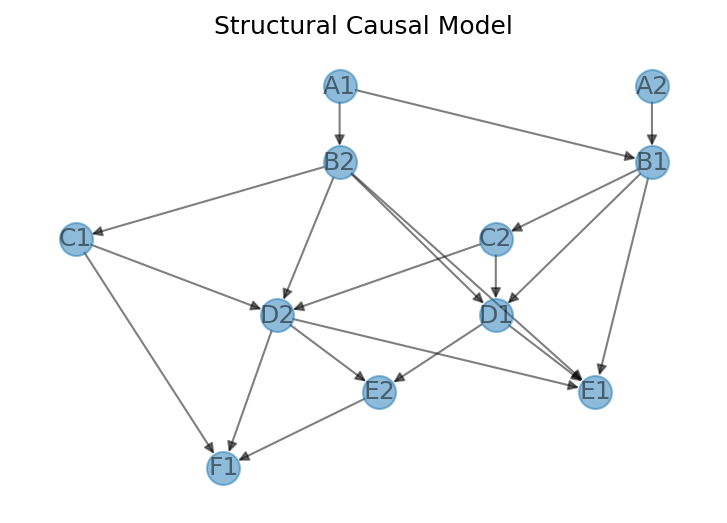

In [16]:
input_nodes = [2,2,2,2,2,1]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [17]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,B2,B1,C1,C2,D1,D2,E1,E2,F1
0,2.658375,0.0,15.950253,2.658375,0.230460,0.390903,4.995444,4.133823,3.118336e+02,16.709410,16.899610
1,2.677566,0.0,16.065399,2.677566,0.661068,0.384349,178.227508,54.496127,8.582855e+04,201.812234,260.382247
2,1.538787,0.0,9.232720,1.538787,2.141408,0.566902,13365.184487,28.851428,3.057256e+06,35491.466514,35517.353353
3,1.454574,0.0,8.727443,1.454574,0.068183,0.052210,497.395244,0.028572,1.124866e+02,4418.609694,4418.616255
4,1.372646,0.0,15.099108,1.372646,0.000010,0.048134,335.638149,0.000014,1.352474e+02,277.318886,277.318886
...,...,...,...,...,...,...,...,...,...,...,...
95,0.846726,0.0,5.080357,0.846726,1.306136,0.211075,4.304766,0.281505,5.146505e+01,22.789118,23.080960
96,1.256739,0.0,7.540432,1.256739,0.334551,0.056166,124.334853,0.485396,4.730625e+02,155.336568,155.567608
97,0.919724,0.0,5.518346,0.919724,0.000003,0.039249,1.680818,0.000001,3.800223e+01,1.341118,1.341118
98,1.553741,0.0,9.322449,1.553741,0.038240,0.491301,146.042828,0.115137,1.449262e+02,429.075463,429.076789


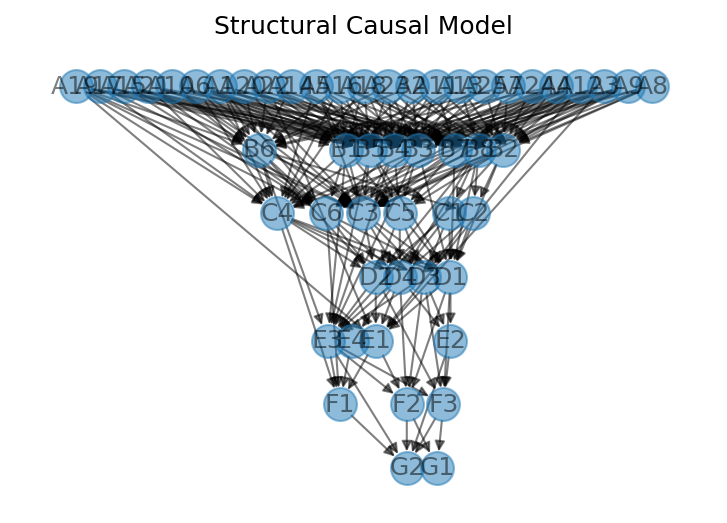

In [18]:
input_nodes = [25, 8, 6, 4, 4, 3, 2]
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [19]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D4,E1,E2,E3,E4,F2,F3,F1,G1,G2
0,1.0,13.018893,0.001094,15.213076,0.0,2.0,0.071134,0.860185,22.0,19.194886,...,2.743267e+10,9.121780,0.000000e+00,5.363492e+23,4.657777e+10,8.381684e+22,0.000000e+00,9.161529e+29,0.000000e+00,0.000000e+00
1,0.0,6.995874,0.023551,2.212983,0.0,3.0,0.175751,0.475209,22.0,21.568944,...,4.515898e+07,21.647352,0.000000e+00,5.678793e+24,3.953933e+07,5.765353e+24,0.000000e+00,2.676870e+34,0.000000e+00,0.000000e+00
2,1.0,9.462873,0.004282,3.232776,0.0,5.0,0.279784,68.550275,22.0,18.031353,...,3.938456e+08,24.416503,0.000000e+00,7.785881e+22,5.732286e+08,5.612319e+22,0.000000e+00,3.191244e+09,-0.000000e+00,0.000000e+00
3,1.0,12.058008,0.312657,7.308390,0.0,5.0,0.611496,1.538019,15.0,22.281387,...,5.807671e+10,14.636239,0.000000e+00,2.655527e+27,1.585773e+11,6.687721e+27,0.000000e+00,3.342486e+37,0.000000e+00,0.000000e+00
4,1.0,8.749074,0.094163,2.768814,1.0,3.0,0.171594,44.075435,22.0,23.494946,...,7.071718e+19,14.809410,0.000000e+00,5.016897e+43,1.078826e+20,7.121382e+42,0.000000e+00,2.847274e+19,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,6.719829,0.274830,25.476200,0.0,7.0,0.116632,59465.545923,22.0,58.585877,...,9.773010e+10,24.601450,3.590008e+15,1.868804e+33,3.600565e+11,5.533027e+32,4.293775e+50,9.281488e+46,5.044773e+84,1.606584e+178
96,1.0,10.053616,0.048296,11.565080,0.0,2.0,0.118211,10.991705,22.0,18.345268,...,2.291250e+10,4.567805,1.800845e+07,3.650748e+22,6.262126e+10,2.086823e+22,4.207636e+31,1.349058e+23,-7.879566e+54,7.359829e+104
97,1.0,15.863151,0.018276,4.371236,0.0,3.0,0.609762,13.786878,22.0,26.946439,...,1.494175e+11,21.737251,1.766364e+13,2.572826e+28,1.798275e+11,1.299487e+28,2.908509e+43,8.146130e+11,-3.752572e+71,5.614891e+123
98,0.0,10.377383,0.425636,30.666749,0.0,7.0,0.026015,2.281479,22.0,33.274574,...,5.998424e+07,8.047990,0.000000e+00,3.897878e+23,5.362984e+07,1.928032e+22,0.000000e+00,1.300713e+33,0.000000e+00,0.000000e+00


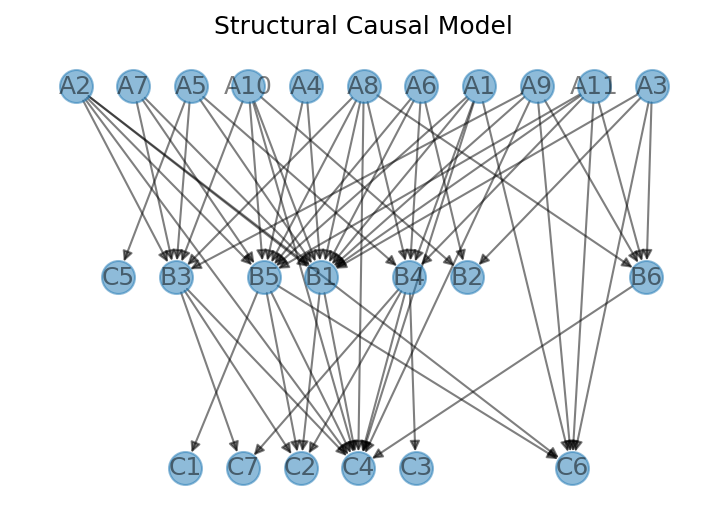

In [23]:
input_nodes = 30
if __name__ == "__main__":  
    if type(input_nodes) == list:
        scm = create_scm_from_nodes_list(input_nodes)
    else:
        scm = create_scm_from_num_nodes(input_nodes)
    scm.plot(node_size=250);

In [24]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,B1,B4,B5,B6,C3,C7,C1,C2,C6,C4
0,0.0,0.0,4.841101,1.952341e-09,0.0,0.194686,12.504555,5.0,5.0,1.0,...,18.944081,0.563517,86.205717,47807.820853,5.071656,901.627782,1.548008e+03,1.810515e+05,5.000000,5.000000e+00
1,0.0,1.0,6.803135,8.985236e-05,1.0,0.705265,12.556336,1.0,5.0,3.0,...,232.746670,3.077875,14.819869,95952.363714,76.946867,0.000000,5.475264e+04,2.358245e+02,20.000000,6.000000e+00
2,0.0,1.0,5.525826,4.315517e+01,1.0,0.020035,6.527110,5.0,5.0,2.0,...,9861.514315,1.563350,26.586358,96626.838478,14.070152,9314.272624,2.648569e+05,2.642609e+05,5.000000,5.000000e+00
3,0.0,1.0,8.089917,1.194943e-02,0.0,0.206981,24.473761,5.0,8.0,3.0,...,342.855406,1.315388,40.440619,107487.997555,11.838492,3367.393215,3.955278e+03,1.718124e+05,8.000000,5.800000e+01
4,0.0,1.0,19.871426,6.569890e+00,1.0,0.236630,15.737487,21.0,8.0,2.0,...,4576.867396,0.549166,55.619953,196470.280218,1.098332,7377.271116,1.032053e+06,1.498929e+06,16.000000,4.700000e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,8.829857,6.421145e+01,1.0,0.179886,24.549816,42.0,7.0,1.0,...,170228.043218,0.473398,53.854766,182923.637927,16.568946,4453.732644,7.212580e+03,1.009393e+06,21.000000,7.000000e+00
96,0.0,0.0,9.956337,3.248144e-08,1.0,0.617493,151.723760,5.0,7.0,3.0,...,167.150900,1.464572,46.044979,111767.267552,13.181150,3383.161861,2.075171e+04,1.355409e+05,28.000000,7.000000e+00
97,0.0,1.0,7.240077,3.808182e+00,0.0,0.050685,13.884816,5.0,5.0,3.0,...,1088.965046,0.682148,31.100263,70870.759405,23.875183,545.718461,6.938098e+03,5.940264e+04,15.000000,5.000000e+00
98,1.0,1.0,4.354224,2.476298e-01,0.0,0.123969,15.698130,5.0,4.0,1.0,...,257.330020,0.663305,228.233438,67705.892182,16.582617,424.514989,2.414832e+04,1.919741e+05,237.050967,4.000000e+00
